In [1]:
# Import modules for HTML display in the notebook and enable inline mode for Matplotlib
from IPython.display import display, HTML, Math, Latex
from IPython.core.magic import register_cell_magic
  
%matplotlib inline

# Import common libraries for data manipulation, optimization, and control
import pandas as pd  # type: ignore
import cvxpy as cp  # type: ignore
from matplotlib.ticker import FuncFormatter, MultipleLocator  # type: ignore
from control.matlab import *  # type: ignore
import control.optimal as opt  # type: ignore
import control as ct  # type: ignore
import matplotlib.pyplot as plt  # type: ignore
import numpy as np  # type: ignore
import matplotlib as mpl  # type: ignore
from matplotlib.patches import FancyArrowPatch # type: ignore
from scipy.integrate import quad # type: ignore
import importlib
import itertools
import csv
import concurrent.futures
from scipy.spatial import ConvexHull
import os, math
import json
from scipy.interpolate import interp1d
import numpy as np
import json
from typing import Dict, List, Any, Optional, Literal


from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

utils_path = os.path.abspath(os.path.join("..", "Utils"))
if utils_path not in sys.path:
    sys.path.append(utils_path)

# Import utility functions from custom modules
import Tex as tex
import Graphs as gph
import Signal as sgn
import Numeric as nm

importlib.reload(tex)
importlib.reload(gph)
importlib.reload(sgn)
importlib.reload(nm)

# Set the use of feedback standards for the control package
ct.use_fbs_defaults()

# Attempt to configure LaTeX for text rendering, otherwise use default Matplotlib fonts
gph.use_latex()

# Set the resolution of figures generated by Matplotlib
mpl.rcParams['figure.dpi'] = 100

cfg = {
    'style': { 'color': 'black', },
    'axis': { 'title_pad': 10, 'y_digits': 1, 'x_digits': 0,
              'x_label_fontsize': 14,
              'y_label_fontsize': 14,
              'tick_fontsize': 14,},
  }


@register_cell_magic
def skip(line, cell):
  return

LaTeX has been enabled for text rendering.


In [2]:
def get_dg_unit_params(R, L, Rt, Lt, Ct, Y, vdc, Be, Pl, vo):
  # Cálculo dos pontos de operação
  io = []
  for k in range(1):
    _io = 0.
    for j in range(2):
      _io += Be[j][k] * vo[j]
    io += [(1. / R[k]) * _io]

  # Corrente do indutor de cada unidade
  it_o = []
  for i in range(2):
    _it_o = 0.
    for k in range(1):
      _it_o += Be[i][k] * io[k]
    it_o += [(Y[i] * vo[i]) + (Pl[i] / vo[i]) + _it_o]

  # Duty cycles de operação
  d_o = []
  for i in range(2):
    d_o += [(vo[i] / vdc[i]) + (Rt[i] / vdc[i]) * it_o[i]]

  # Create the dictionary of parameters
  params = {'R': R, 'L': L, 'Rt': Rt,  'Lt': Lt, 'Ct': Ct, 'Y': Y, 'vdc': vdc,
            'Be': Be, 'Pl': Pl, 'v_o': vo, 'i_o': io, 'it_o': it_o, 'd_o': d_o}

  return params

In [3]:
def get_A(ρ, params):

  Y = np.diag(params['Y'])
  L = np.diag(params['L'])
  R = np.diag(params['R'])
  vo = np.diag(params['v_o'])
  Be = np.array(params['Be'])
  Ct = np.diag(params['Ct'])
  Lt = np.diag(params['Lt'])
  Rt = np.diag(params['Rt'])

  # Obtenção dos parâmetros \rho
  δv = np.diag(ρ[0:2])
  Pl = np.diag(ρ[2:4])

  Ct_inv = np.linalg.inv(Ct)
  Lt_inv = np.linalg.inv(Lt)
  L_inv = np.linalg.inv(L)
  vo_inv = np.linalg.inv(vo)
  v_inv = np.linalg.inv(vo + δv)

  A11 = - Ct_inv @ Y + Ct_inv @ vo_inv @ v_inv @ Pl
  A12 = Ct_inv
  A13 = - Ct_inv @ Be
  A21 = - Lt_inv
  A22 = - Lt_inv @ Rt
  A23 = np.zeros((A22.shape[0], A13.shape[1]))
  A31 = L_inv @ Be.T
  A32 = np.zeros((A31.shape[0], A22.shape[1]))
  A33 = - L_inv @ R

  return np.block([[A11, A12, A13],
                   [A21, A22, A23],
                   [A31, A32, A33]])


def get_B(ρ, params):
  Lt = np.diag(params['Lt'])
  Lt_inv = np.linalg.inv(Lt)

  vdc = np.diag(params['vdc'])
  B11 = np.zeros((2, 2))
  B21 = - Lt_inv @ vdc
  B31 = np.zeros((1, 2))
  return np.block([[B11],
                   [B21],
                   [B31]])

In [20]:
simulation_step = 1e-5
simulation_time = .1
timepts = np.arange(0, simulation_time + simulation_step, simulation_step)

# Entrada para simulação em malha aberta
u = np.zeros((len(timepts), 1))

ρ_bounds = np.array([
    # Limites das tensões
    [-2.0, 2.0],
    [-2.0, 2.0],
    # Limites da potência
    [-20, 20],
    [-20, 20],])

x_bounds = [(-2,  2.),
            (-2., 2.),
            (-2., 2.),
            (-2., 2.),
            (-2., 2.)]

# Conexões das linhas de potência:
Be = [[1.],
      [-1]]

R = [0.5]              # Resistências das linhas de potência (Ω)
L = [1e-3]      # Indutâncias das linhas de potência (H)
Rt = [1e-1, 1e-1]         # Resistência em série do indutor (Ω)
Lt = [1e-3, 1e-3]         # Indutância do filtro (H)
Ct = [2.2e-3, 2.2e-3]   # Indutância do filtro (H)
Y = [2e-1, 2e-1]
vdc = [15, 24]            # Tensão de entrada de cada unidade (V)
Pl = [15, 24]             # Potência da CPL no PO (W)
vo = [5, 9]             # Tensão de operação dos capacitores (V)

dg_params = get_dg_unit_params(R, L, Rt, Lt, Ct, Y, vdc, Be, Pl, vo)
display(dg_params)

u_bar = []
for i in range(2):
  u_bar += [min(1 - dg_params['d_o'][i], dg_params['d_o'][i])]

{'R': [0.5],
 'L': [0.001],
 'Rt': [0.1, 0.1],
 'Lt': [0.001, 0.001],
 'Ct': [0.0022, 0.0022],
 'Y': [0.2, 0.2],
 'vdc': [15, 24],
 'Be': [[1.0], [-1]],
 'Pl': [15, 24],
 'v_o': [5, 9],
 'i_o': [-8.0],
 'it_o': [-4.0, 12.466666666666667],
 'd_o': [0.30666666666666664, 0.42694444444444446]}

In [21]:
Pl1 = Pl[0] + sgn.step_signal(timepts, [0.02, 0.05, 0.07], [15, -5., 7.5])
Pl2 = Pl[0] + sgn.step_signal(timepts, [0.04, 0.08], [10, 15])

In [22]:
fig = plt.figure(figsize=(16, 3), layout='constrained')
axs = fig.subplot_mosaic([["Pl1", "Pl2"]])

gph.plot(
    axs['Pl1'],
    timepts, Pl1,
    't (s)',
    '$p_1$',
    'Parâmetro $p_1(t)$',
)
gph.plot(
    axs['Pl2'],
    timepts, Pl2,
    't (s)',
    '$p_1$',
    'Parâmetro $p_1(t)$',
)
plt.tight_layout()

/tmp/ipykernel_5689/3883504124.py:18: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


In [7]:
def plant_dynamics(time, x, inputs, params):
  # Extracting the number of inputs and parameters
  n_u = 2
  n_p = 4

  # Splitting inputs into u (control inputs) and p (parameters)
  _u = inputs[0:n_u][:].reshape(-1, 1)
  ρ = inputs[n_u:n_u + n_p][:].flatten()

  # Getting the system matrices A and B
  A = get_A(ρ, params)
  B = get_B(ρ, params)

  # Computing the time derivative of the state
  # s (x_dot)
  x_dot = A @ x + B @ _u

  return x_dot


def plant_output(t, x, u, params):
  return x

## Simulação da Planta em Malha Aberta

In [8]:
def openloop_simulation(x0, plant_dynamics, plant_output,
                        timepts, T_s, params):
  """
  Simula um sistema de controle em malha aberta com integração RK5.

  Args:
      x0 (np.ndarray): Estado inicial, shape (n, 1)
      plant_dynamics (callable): Dinâmica do sistema f(t, x, u, params)
      plant_output (callable): Função de saída h(t, x, u, params)
      u_til (np.ndarray): Entradas estendidas, shape (N, m, 1)
      timepts (np.ndarray): Vetor de instantes de tempo, shape (N,)
      T_s (float): Passo de simulação
      params (dict): Parâmetros do sistema

  Returns:
      list[np.ndarray]: Lista com N+1 elementos, cada um de shape (n_y, 1),
                        contendo a saída em cada instante.
  """
  N = len(timepts)
  n = x0.shape[0]

  # Inicialização do estado
  x = np.zeros((n, N, 1))
  x[:, 0, :] = x0

  y = []

  for k, t in enumerate(timepts):
    _x = x[:, k, :].flatten()
    util = np.vstack((u[k], u[k],
                      _x[0], _x[1],
                      Pl1[k], Pl2[k]))

    y.append(plant_output(t, x[:, k, :], util, dg_params))

    if k < N - 1:
      x[:, k + 1, :] = nm.rk5_step(
          plant_dynamics, t, x[:, k, :], util, T_s, dg_params
      )

  return y

In [9]:
x0 = np.array([[.4], [.4],
               [.4], [.4],
               [.4]])
y = openloop_simulation(x0, plant_dynamics, plant_output,
                        timepts, simulation_step, dg_params)

/tmp/ipykernel_5689/432985271.py:20: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


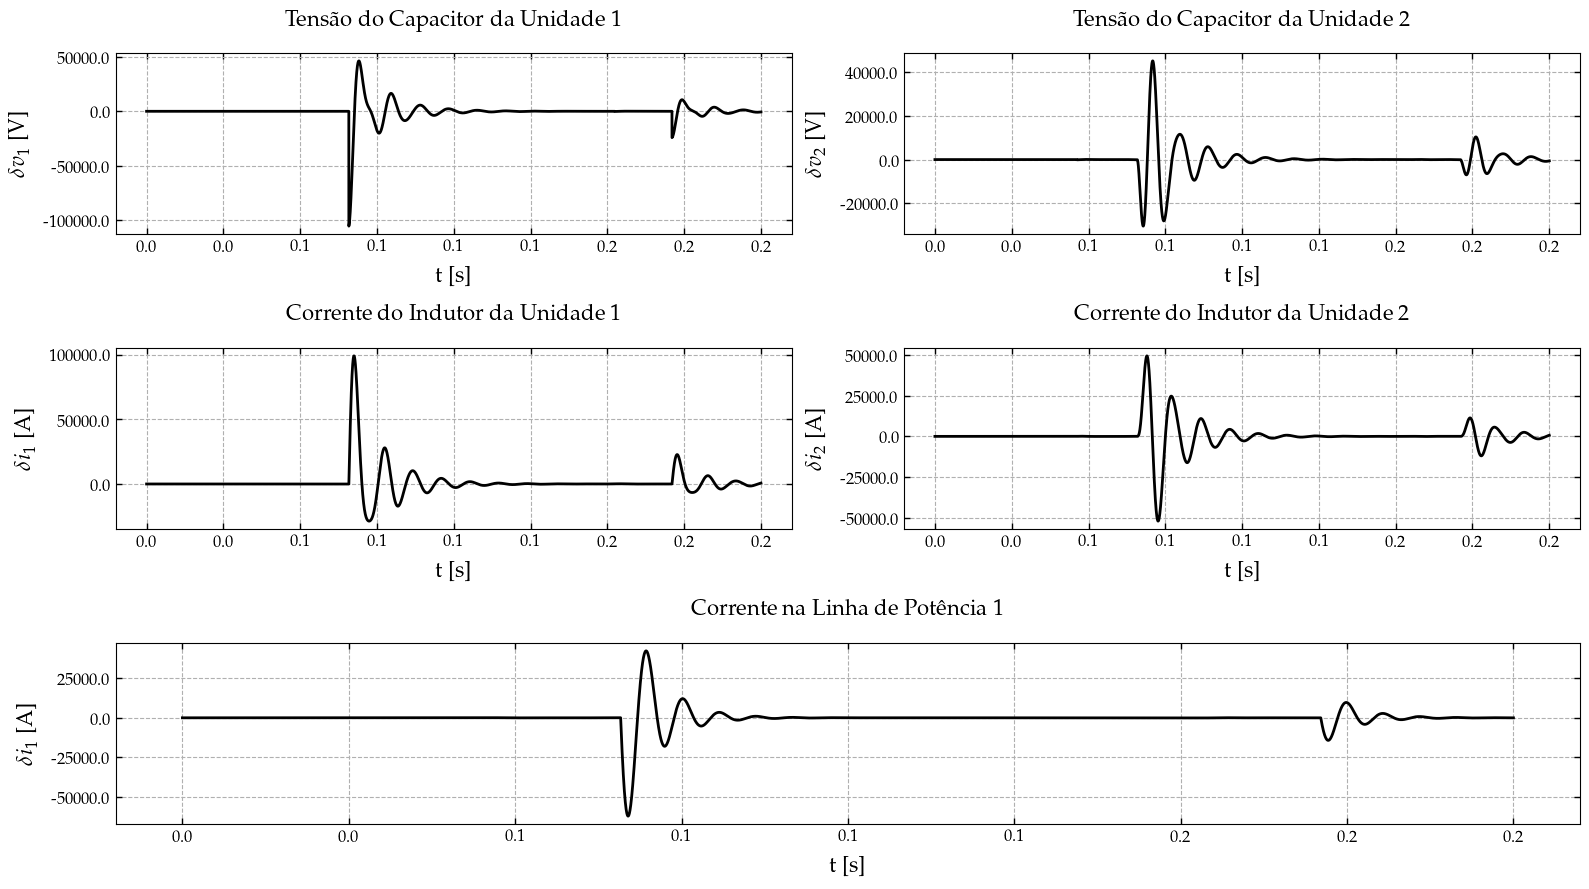

In [10]:
fig = plt.figure(figsize=(16, 9), layout='constrained')

mosaic = [['δv1', 'δv2'],
          ['δit1', 'δit2'],
          ['δi1', 'δi1']]
axs = fig.subplot_mosaic(mosaic)

for i in range(2):
  gph.plot(axs[mosaic[0][i]], timepts, [v[i] for v in y],
           't [s]', f'$\\delta v_{i+1}$ [V]',
           f'Tensão do Capacitor da Unidade {i+1}',)
for i in range(2):
  gph.plot(axs[mosaic[1][i]], timepts, [v[2+i] for v in y],
           't [s]', f'$\\delta i_{i+1}$ [A]',
           f'Corrente do Indutor da Unidade {i+1}',)
for i in range(1):
  gph.plot(axs[mosaic[2][i]], timepts, [v[4+i] for v in y],
           't [s]', f'$\\delta i_{i+1}$ [A]',
           f'Corrente na Linha de Potência {i+1}',)
plt.tight_layout()

In [11]:
def solve_problem(
    h: float,
    υ: float,
    σ_til: float = 0.5,
    eps: float = 1e-6
):
  nu = 2
  n_p = 4
  n_x = 5

  Bnp = list(itertools.product([0, 1], repeat=n_p))
  Onx = np.zeros((n_x, n_x))

  A = {}
  B = {}

  u_bar = []
  for i in range(nu):
    u_bar += [min(1 - dg_params['d_o'][i], dg_params['d_o'][i])]

  for i in Bnp:
    ρi = [ρ_bounds[idx][i[idx]] for idx in range(n_p)]
    A[i] = cp.Parameter((n_x, n_x), name=f'A[{i}]', value=get_A(ρi, dg_params))
    B[i] = cp.Parameter((n_x, nu), name=f'B[{i}]', value=get_B(ρi, dg_params))

  e = nm.get_e(5 * [n_x] + [nu])

  for i in range(1, len(e)):
    e[i] = cp.Parameter(e[i].shape, value=e[i], name=f"e{i}")

  constraints = []

  Ptil = cp.Variable((n_x, n_x), PSD=True)
  Mtil = cp.Variable((2 * n_x + nu, 2 * n_x + nu), PSD=True)
  Q1til = cp.Variable((n_x, n_x), symmetric=True)
  Q2til = cp.Variable((n_x, n_x))
  Q3til = cp.Variable((n_x, nu))
  Q4til = cp.Variable((n_x, n_x))
  S1til = cp.Variable((n_x, n_x), symmetric=True)
  S2til = cp.Variable((n_x, n_x))
  S3til = cp.Variable((n_x, nu))
  S4til = cp.Variable((n_x, n_x))

  Ktil = cp.Variable((nu, n_x), name=f'K')
  L1til = cp.Variable((nu, n_x), name=f'L1')
  L2til = cp.Variable((nu, n_x), name=f'L2')
  ℵ = cp.Variable((nu, nu), diag=True)
  constraints += [ℵ >> eps * np.eye(ℵ.shape[0])]

  Rtil = cp.Variable((n_x, n_x), PSD=True)
  Ξtil = cp.Variable((n_x, n_x), PSD=True)
  β = cp.Variable(pos=True)

  X = cp.Variable((n_x, n_x))
  Ytil = cp.Variable((2 * n_x, e[1].shape[1]))

  Rcal = cp.bmat([[Rtil, Onx],
                  [Onx, 3. * Rtil]])

  Fscr = e[1].T + υ * e[2].T + υ * e[4].T

  κ1 = cp.bmat([[e[2]], [e[6]], [e[5]]])
  κ2 = cp.bmat([[e[1] - e[2]],
                [e[1] + e[2] - 2. * e[3]]])

  def get_Λ(i):
    Bscr = A[i] @ X @ e[1] + B[i] @ Ktil @ e[2] - \
        X @ e[4] + B[i] @ Ktil @ e[5] - B[i] @ ℵ @ e[6]

    Θ1 = (e[1] - e[2]).T @ S1til @ (e[1] - e[2]) + \
        nm.He((e[1] - e[2]).T @ (S2til @ e[2] + S3til @ e[6] + S4til @ e[5]))

    Θ2 = nm.He(e[3].T @ (Q2til @ e[2] + Q3til @ e[6] + Q4til @ e[5]))

    Θ3 = nm.He(e[1].T @ (Q1til @ e[3] + Q2til @ e[2] +
                         Q3til @ e[6] + Q4til @ e[5]))
    Θ4 = - nm.He(e[6].T @ ℵ @ e[6] - e[6].T @ L1til @ e[2] -
                 e[6].T @ L2til @ e[5])

    Θtil = {}
    Θtil['0'] = - Θ1 - h * e[3].T @ Q1til @ e[3] + \
        h * Θ3 + h * κ1.T @ Mtil @ κ1 + h * e[4].T @ Rtil @ e[4] + Θ4 + \
        nm.He(e[1].T @ Ptil @ e[4] + Fscr @ Bscr - κ2.T @ Ytil)

    Θtil['h'] = - Θ1 - h * Θ2 - h * e[3].T @ Q1til @ e[3] - \
        h * κ1.T @ Mtil @ κ1 + Θ4 + \
        nm.He(e[1].T @ Ptil @ e[4] + Fscr @ Bscr - κ2.T @ Ytil)

    Θtil['0'] += e[2].T @ Ξtil @ e[2] - σ_til * e[5].T @ Ξtil @ e[5]
    Γ1_11 = Θtil['0']
    Γ1 = cp.bmat([[Γ1_11]])

    Θtil['h'] += e[2].T @ Ξtil @ e[2] - σ_til * e[5].T @ Ξtil @ e[5]
    Γ2_11 = Θtil['h']
    Γ2_12 = Ytil.T

    Γ2_21 = Γ2_12.T
    Γ2_22 = - (1. / h) * Rcal

    Γ2 = cp.bmat([[Γ2_11, Γ2_12],
                  [Γ2_21, Γ2_22]])

    return Γ1, Γ2

  for i in Bnp:
    Λ = {}
    Λ['0'], Λ['h'] = get_Λ(i)

    constraints += [Λ['0'] << -eps * np.eye(Λ['0'].shape[0])]
    constraints += [Λ['h'] << -eps * np.eye(Λ['h'].shape[0])]

  for ell in range(nu):
    LMISAT11 = Ptil - Ξtil
    LMISAT12 = np.zeros((n_x, n_x))
    LMISAT14 = (Ktil[ell:ell+1] - L1til[ell:ell+1]).T

    LMISAT21 = LMISAT12.T
    LMISAT22 = (1. / σ_til) * Ξtil
    LMISAT24 = (Ktil[ell:ell+1] - L2til[ell:ell+1]).T

    LMISAT41 = LMISAT14.T
    LMISAT42 = LMISAT24.T
    LMISAT44 = (u_bar[ell] ** 2) * np.eye(1)

    LMISAT = cp.bmat(
        [[LMISAT11, LMISAT12, LMISAT14],
         [LMISAT21, LMISAT22, LMISAT24],
         [LMISAT41, LMISAT42, LMISAT44]])

    constraints += [LMISAT >> 0.]

  LMID0_11 = β * np.eye(n_x)
  LMID0_12 = np.eye(n_x)
  LMID0_21 = np.eye(n_x)
  LMID0_22 = X + X.T - Ptil

  LMID0 = cp.bmat([[LMID0_11, LMID0_12],
                   [LMID0_21, LMID0_22]])

  aq = nm.get_vertices(x_bounds)

  for i in range(len(aq)):
    LMI_D11 = Ptil
    LMI_D12 = X.T @ aq[i]
    LMI_D21 = LMI_D12.T
    LMI_D22 = np.eye(1)

    LMI_D = cp.bmat([[LMI_D11, LMI_D12],
                     [LMI_D21, LMI_D22]])

    constraints += [LMI_D >> 0]

  constraints += [LMID0 >> eps * np.eye(LMID0.shape[0])]

  # if '-neq' in etm_type:
  # constraints += [Ψtil >> eps * np.eye(n_x)]
  constraints += [Ξtil >> eps * np.eye(n_x)]

  obj = cp.Minimize(β)
  prob = cp.Problem(obj, constraints)

  # Solve the problem using the MOSEK solver
  prob.solve(solver=cp.SCS, verbose=False, ignore_dpp=True)
  # prob.solve(solver=cp.MOSEK, verbose=False, ignore_dpp=True)

  # Initialize variables to store results
  design_results = None

  # Display the results
  if prob.status not in ["infeasible", "unbounded"]:
    Xinv = np.linalg.inv(X.value)
    Ξ = Xinv.T @ Ξtil.value @ Xinv
    P = Xinv.T @ Ptil.value @ Xinv
    S2 = Xinv.T @ S2til.value @ Xinv

    error = False

    if error == False:
      K = Ktil.value @ Xinv
      L1 = L1til.value @ Xinv
      L2 = L2til.value @ Xinv

      etm_results = {'Ξ': Ξ}
      design_results = {
          'optimal_value': prob.value,
          'etm': etm_results,
          'controller': {'K': K, 'L1': L1, 'L2': L2},
          'lyapunov': [P, S2],
      }
  else:
    # print('The problem is not feasible')
    design_results = None

  return design_results

In [12]:
# Definição inicial das variáveis
Ξ = Ψ = K = L1 = P = γ = β = None
Θ, λ = None, None

# Parâmetros e resolução do problema
h = 1e-3       # Período de amostragem (em segundos)
υ = 1e-4        # Parâmetros de projeto

σ_bar = .5
σ_til = 350

prob_res = solve_problem(h, υ, σ_til, eps=1e-6)

if prob_res is not None:
  Ξ = prob_res['etm']['Ξ']
  K, L1, L2 = prob_res['controller']['K'], prob_res['controller']['L1'], \
      prob_res['controller']['L2']
  P, S2 = prob_res['lyapunov']

  # print(f'β = {β:.3e}')

  display(Math(rf'\Xi = {tex.mat2tex(Ξ)}'))
  display(Math(rf'P = {tex.mat2tex(P)}'))

  # for i in nm.binary_set(4):
  #   display(Math(rf'K_{{{i}}} = {tex.mat2tex(K[i])}'))
  #   display(Math(rf'L_{{{i}}} = {tex.mat2tex(L1[i])}'))
else:
  print('Problema não é factível!')

/home/andel-vitorio/.control_venv/lib/python3.12/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [13]:
# %matplotlib inline

# fig, ax = plt.subplots(1, 1, figsize=(6., 6.))

# # Definindo intervalo de plotagem
# x1_range = (-5, 5)
# x2_range = (-5, 5)
# num_points = 20

# # a_q = nm.get_vertices(x_bounds)

# B4 = nm.binary_set(4)
# u_bar = sys.get_u_bar()

# x_vals = np.linspace(x1_range[0], x1_range[1], int(1e3))
# y_vals = np.linspace(x2_range[0], x2_range[1], int(1e3))


# X, Y = np.meshgrid(x_vals, y_vals)
# points = np.vstack([X.ravel(), Y.ravel()]).T
# Du_region = np.ones(X.shape, dtype=bool)
# for b in B4:
#   result = np.abs(points @ (K[b] - L1[b]).T)
#   Du_region &= (result.reshape(X.shape) <= u_bar[0])
# ax.contour(X, Y, Du_region, colors='#084475', linewidths=1.27)

# X0_list = nm.ellipsoid_boundary_points(P, 1, num_points)
# plt.plot(X0_list[0], X0_list[1], '*',
#          linestyle='None', c='black', markersize=12)

# D0 = nm.get_ellipsoid_boundary(P, 1)
# plt.plot(D0['x1_vals'], D0['x2_vals'],
#          'k-', label='')

# μ_inv = 1. + (1. / (γ * δ))
# Dx = nm.get_ellipsoid_boundary(P, μ_inv)
# plt.plot(Dx['x1_vals'], Dx['x2_vals'],
#          'k-', label='')

# # Ajustes finais de layout
# ax.set_title("Regions")
# ax.set_xlabel("$x_1$")
# ax.set_ylabel("$x_2$")
# ax.grid(True)

# # Exibir o gráfico
# plt.tight_layout()

In [ ]:
def closedloop_simulation(x0, σ0, σ_til, T_s):

  if (x0.T @ P @ x0).item() > 1.0:
    raise ValueError(
        "O estado inicial x0 não pertence a região de estados iniciais estimada. \n A simulação será interrompida pois os resultados não são garantidos.")

  N = len(timepts)
  nx = x0.shape[0]

  x = np.zeros((nx, N + 1, 1), dtype=np.float64)
  x[:, 0, :] = x0.astype(np.float64)

  σ = np.full((N + 1, 1), 0., dtype=np.float64)
  σ[0, :] = np.float64(σ0)

  ρ0 = [x0[0][0], x0[1][0], Pl1[0], Pl2[0]]

  xτ = x0.copy().astype(np.float64)
  x_hat = x0.copy().astype(np.float64)
  ρ_hat = np.array(ρ0, dtype=np.float64).reshape(-1, 1)

  y = []
  uc = []
  event_times = [0.]

  next_time_sampling = h

  def triggering_condition(_σ, _xτ, _ε):
    v1 = _σ * (_xτ.T @ Ξ @ _xτ)
    v2 = _ε.T @ Ξ @ _ε
    diff = v1 - v2
    return diff < -1e-9

  def signa_dynamics(t, _σ, u, params):
    _ε = x_hat - xτ
    ε_quad = _ε.T @ Ξ @ _ε
    σ_dot = (1. / _σ) * ((1. / _σ) - σ_til) * ε_quad
    return σ_dot

  def control_signal():
    u_total = K @ x_hat

    # Apply saturation element-wise
    u_sat = np.zeros_like(u_total)
    for i in range(2):
      u_sat[i, 0] = sgn.sat(u_total[i, 0], u_bar[i])

    return u_sat

  for k, t in enumerate(timepts):
    _x = x[:, k, :].flatten()

    # Verificação da condição de acionamento
    if t >= next_time_sampling:
      next_time_sampling += h
      xτ = x[:, k, :].copy()
      ε = x_hat - xτ
      if triggering_condition(σ[k], xτ, ε):
        ρ_hat = [_x[0], _x[1], Pl1[k], Pl2[k]]
        x_hat = xτ.copy()
        event_times.append(t)

    # Cálculo do sinal de controle
    u_sat = control_signal()
    ρ = [_x[0], _x[1], Pl1[k], Pl2[k]]
    inputs_vec = np.hstack((u_sat.flatten(), ρ)).ravel()

    # Saída da planta
    y.append(plant_output(t, x[:, k, :], inputs_vec, ρ))

    # Atualização dos estados
    if k < N:
      x[:, k + 1, :] = nm.rk5_step(
          plant_dynamics, t, x[:, k, :], inputs_vec, T_s, dg_params
      )

      # σ_next = nm.rk5_step(
      #     signa_dynamics, t, σ[k, :], None, T_s, None)
      # σ[k + 1, :] = np.maximum(σ_next, 1e-6)

    uc.append(u_sat)

  return y, uc, σ[:N], event_times

In [24]:
# Nome do arquivo de experimento
experiment_name = "Results/nb2/ClosedLoop_Results_n1.json"
force_simulation = True
simulations_amount = 1

# Estrutura para armazenar os resultadosevent_times
results_clsim = {
    'inter-event-times': [],
    'control-signal': [],
    'trajectories': [],
    'sigma': [],
}

# Função para converter arrays e listas aninhadas em estruturas serializáveis


def convert_to_serializable(obj):
  if isinstance(obj, np.ndarray):
    return obj.tolist()
  elif isinstance(obj, list):
    return [convert_to_serializable(item) for item in obj]
  elif isinstance(obj, dict):
    return {key: convert_to_serializable(val) for key, val in obj.items()}
  return obj

# Função para converter de volta para arrays


def convert_to_numpy(obj):
  return {
      'trajectories': [np.array(y_k) for y_k in obj['trajectories']],
      'control-signal': [np.array(u_k) for u_k in obj['control-signal']],
      'sigma': [np.array(sigma_k) for sigma_k in obj['sigma']],
      'inter-event-times': obj['inter-event-times'],
  }


# Verificar se o arquivo já existe
if os.path.exists(experiment_name) and not force_simulation:
  print(f"O arquivo {experiment_name} já existe. Carregando dados salvos.")
  with open(experiment_name, "r") as f:
    loaded = json.load(f)
    results_clsim = convert_to_numpy(loaded)
else:
  def get_trajectories(i):
    # x0 = np.array([[X0_list[0][i]], [X0_list[1][i]]])
    x0 = np.array([[1.], [1.], [.5], [.5], [.75]])
    σ0 = np.array([[0.68]])

    y, uc, σ, event_times = closedloop_simulation(
        x0, σ0, σ_til, T_s=simulation_step)
    inter_event_times = np.diff(event_times).tolist()

    return {
        'trajectories': y,
        'sigma': σ,
        'control-signal': uc,
        'inter-event-times': inter_event_times
    }

  # Paralelismo com ProcessPoolExecutor
  with concurrent.futures.ProcessPoolExecutor() as executor:
    results = list(executor.map(get_trajectories,
                                range(simulations_amount)))

  # Atualizar estrutura de resultados
  for res in results:
    results_clsim['trajectories'].append(res['trajectories'])
    results_clsim['inter-event-times'].append(res['inter-event-times'])
    results_clsim['control-signal'].append(res['control-signal'])
    results_clsim['sigma'].append(res['sigma'])

  # Serializar e salvar
  results_serializable = convert_to_serializable(results_clsim)

  with open(experiment_name, "w") as f:
    json.dump(results_serializable, f, indent=2)

  print(f"Simulações concluídas. Resultados salvos em {experiment_name}.")

/tmp/ipykernel_5689/3279391223.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  σ[0, :] = np.float64(σ0)


Simulações concluídas. Resultados salvos em Results/nb2/ClosedLoop_Results_n1.json.


In [25]:
%matplotlib inline

simulation_index = 0
inter_event_times = results_clsim['inter-event-times'][simulation_index]
uc = results_clsim['control-signal'][simulation_index]
y = results_clsim['trajectories'][simulation_index]
σ = results_clsim['sigma'][simulation_index]

# iet_f, iet_unit, iet_dp = nm.format_magnitudes(
#     inter_event_times, 's', use_prefixes=True, n_divs=5)

event_times = np.cumsum(inter_event_times)

axis_limits = {'x_min': 0., 'x_max': timepts[-1]}

print("Estado Inicial: ", y[0].reshape(-1))
print("Número de Eventos Acionados: ", len(inter_event_times))
print("Menor IET Obtido: ", min(inter_event_times))
print("Máximo IET Obtido: ", max(inter_event_times))
print("Média do Intervalos de Tempo entre Eventos: ", np.mean(
      inter_event_times) )

Estado Inicial:  [1.   1.   0.5  0.5  0.75]
Número de Eventos Acionados:  64
Menor IET Obtido:  0.000999999999999987
Máximo IET Obtido:  0.0030000000000000027
Média do Intervalos de Tempo entre Eventos:  0.0015470312500000002


In [26]:
%matplotlib qt

fig = plt.figure(figsize=(6, 9), layout='constrained')

mosaic = [['δv1'],
          ['δit1'],
          ['δi1']]
axs = fig.subplot_mosaic(mosaic)

gph.plot(axs[mosaic[0][i]], timepts, [v[0] for v in y],
         't [s]', f'$\\delta v$ [V]',
         f'Capacitor Voltages',
         label='DG 1',
         plot_cfg={**cfg,
                   'axis': {**cfg['axis'], 'x_digits': 2, 'y_digits': 2},
                   'style': {**cfg['style'], 'color': '#084475'},
                   'limits': axis_limits, })

gph.plot(axs[mosaic[0][i]], timepts, [v[1] for v in y],
         't [s]', f'$\\delta v$ [V]',
         f'Capacitor Voltages',
         label='DG 2',
         plot_cfg={**cfg,
                   'axis': {**cfg['axis'], 'x_digits': 2, 'y_digits': 2},
                   'style': {**cfg['style'], 'color': 'black'},
                   'limits': axis_limits, })

gph.plot(axs[mosaic[1][i]], timepts, [v[2] for v in y],
         't [s]', f'$\\delta i_t$ [A]',
         f'Inductor Current',
         label='DG 1',
         plot_cfg={**cfg,
                   'axis': {**cfg['axis'], 'x_digits': 2, 'y_digits': 2},
                   'style': {**cfg['style'], 'color': '#084475'},
                   'limits': axis_limits, })

gph.plot(axs[mosaic[1][i]], timepts, [v[3] for v in y],
         't [s]', f'$\\delta i_t$ [A]',
         f'Inductor Current',
         label='DG 2',
         plot_cfg={**cfg,
                   'axis': {**cfg['axis'], 'x_digits': 2, 'y_digits': 2},
                   'style': {**cfg['style'], 'color': 'black'},
                   'limits': axis_limits, })

for i in range(1):
  gph.plot(axs[mosaic[2][i]], timepts, [v[4+i] for v in y],
           't [s]', f'$\\delta i$ [A]',
           f'Power Line Current',
           label='Line 1',
           plot_cfg={**cfg,
                     'axis': {**cfg['axis'], 'x_digits': 2,
                              'y_digits': 2},
                     'limits': axis_limits, })
plt.tight_layout()

IndexError: list index out of range

In [ ]:
%matplotlib qt


fig = plt.figure(figsize=(6, 3), layout='constrained')

mosaic = [['δd']]
axs = fig.subplot_mosaic(mosaic)

gph.plot(axs[mosaic[0][0]], timepts, [v[0] * 1e2 for v in uc],
         't [s]', f'$\\delta v_{i+1}$ [V]',
         label='DG 1',
         plot_cfg={**cfg,
                   'axis': {**cfg['axis'], 'x_digits': 2, 'y_digits': 0},
                   'style': {**cfg['style'], 'color': '#084475'},
                   'limits': axis_limits, })

gph.plot(axs[mosaic[0][0]], timepts, [v[1] * 1e2 for v in uc],
         't [s]', f'$\\delta d \\;$ [$10^{{-2}}$]',
         f'Duty Cycles',
         label='DG 2',
          plot_cfg={**cfg,
                   'axis': {**cfg['axis'], 'x_digits': 2, 'y_digits': 0},
                   'style': {**cfg['style'], 'color': 'black'},
                   'limits': axis_limits, })

# axs['δd1'].hlines([u_bar[0], -u_bar[0]], 0, timepts[-1], colors='black',
#                   linestyles='--', label='$\\pm \\overline{u}$', linewidths=2.)
# axs['δd1'].legend(prop={'size': 16})

# axs['δd2'].hlines([u_bar[1], -u_bar[1]], 0, timepts[-1], colors='black',
#                   linestyles='--', label='$\\pm \\overline{u}$', linewidths=2.)
# axs['δd2'].legend(prop={'size': 16})

In [ ]:

%matplotlib qt

fig = plt.figure(figsize=(6, 6), layout='constrained')

mosaic = [['sigma'], ['iet']]
axs = fig.subplot_mosaic(mosaic)

print(σ[-1])

gph.plot(
    axs['sigma'], timepts, [σi * 1e2 for σi in σ],
    xlabel='$t$ [s]', ylabel='$\\sigma(t)\\,$ [$10^{-2}$]',
    title='ETM\'s Parameter',
    plot_cfg={**cfg,
              'axis': {**cfg['axis'], 'x_digits': 2,
                       'y_digits': 0},
              'limits': axis_limits,
              })

# Plot dos IETs
if len(inter_event_times) > 0:
  stem_cfg = cfg.copy()
  stem_cfg['axis']['y_digits'] = 0

  gph.stem(
      axs['iet'], event_times, [iet * 1e3 for iet in inter_event_times],
      xlabel='$t$ [s]', ylabel='$t_{k+1} - t_k\\;$ [ms]',
      title='Inter-event Time',
      stem_cfg={**cfg,
                'axis': {**cfg['axis'], 'x_digits': 2,
                         'y_digits': 0},
                'limits': axis_limits, }
  )


else:
  axs['iet'].text(0.5, 0.5, 'No triggered events',
                  ha='center', va='center', fontsize=14,
                  transform=axs['iet'].transAxes)
  axs['iet'].set_title('Inter-event Times')
  axs['iet'].set_xlabel('t [ms]')
  axs['iet'].set_ylabel('$t_{k+1} - t_k$ [$ms$]')
  axs['iet'].set_xlim([0, simulation_time])
  axs['iet'].set_ylim([0, 1])  # valor simbólico
  axs['iet'].grid(False)

plt.tight_layout(pad=2.)

[0.68758735]


ValueError: x and y must have same first dimension, but have shapes (10001,) and (20001, 1)